In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import Table

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_excel('Dataset.xlsx')

## Clean Data

In [3]:
# Get the list of columns to convert to categorical
categorical_columns = df.select_dtypes(include='int64').columns.tolist()

# Convert the selected columns to categorical
df[categorical_columns] = df[categorical_columns].astype('category')

numeric_data = df.select_dtypes(include=[np.number])

# Calculate MAD for each column
mad = numeric_data.mad()

# Choose a threshold multiplier
k = 3

# Calculate the threshold value
threshold = k * mad

# Identify outliers
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Apply logarithm to the specified columns
outlier_columns = ['CommissionSacrificePercentage', 'BonusCommissionPercentage']
for column in outlier_columns:
    df[column] = np.log1p(df[column])

numeric_data = df.select_dtypes(include=[np.number])

# Check that all outliers have been handled
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Count the number of outliers in each column
outlier_counts = outliers.sum()

# Create a new DataFrame from outlier_counts
outlier_table = pd.DataFrame({'Column': outlier_counts.index, 'Outlier Count': outlier_counts.values})

# Display the table
print(outlier_table)

                          Column  Outlier Count
0  CommissionSacrificePercentage              0
1      BonusCommissionPercentage              0


In [4]:
X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create new DataFrames for training and testing data
df = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


# Feature Importance Techniques

In [5]:
# Define features and target variable
features = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']
target = 'PolicyIssued'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])


### Random Forest Feature Importance Scoring

In [7]:
# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

# Print feature importances
print("Feature Importances:")
print(feature_importances)


Feature Importances:
Agency                     0.567376
WorkflowStatus             0.174382
UWDecision                 0.105368
CommDateProvided           0.034927
SignedDecReceived          0.014224
NoOfLives                  0.013520
BonusCommission            0.012435
Product                    0.011422
SeriousIllnessType         0.011337
CommissionTerms            0.011093
ProductGroup               0.011068
Indexation                 0.009994
ProductType                0.005567
CommissionSacrificeType    0.003942
RenewalSacrificeType       0.003927
ComissionSacrifice         0.003182
Discount                   0.003100
PaymentFreq                0.002632
FreeCover                  0.000504
dtype: float64


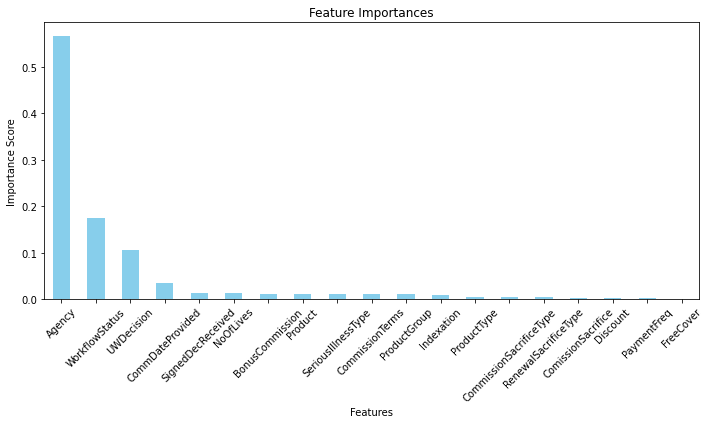

In [8]:
# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Select the top-n features based on importance
n = 19
selected_features = feature_importances[:n].index.tolist()


In [10]:
# Create a new dataset with the selected features
selected_data = df[selected_features + [target]]


In [11]:
# Conduct experiments by training and evaluating the model on different feature combinations
for feature_combination in range(1, n + 1):
    selected_features_combination = selected_features[:feature_combination]
    X_train_combination = X_train[selected_features_combination]
    X_test_combination = X_test[selected_features_combination]

    rf_classifier_combination = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_combination.fit(X_train_combination, y_train)
    y_pred_combination = rf_classifier_combination.predict(X_test_combination)

    accuracy = accuracy_score(y_test, y_pred_combination)
    report = classification_report(y_test, y_pred_combination)
    print(f"\nExperiment with {feature_combination} features:")
    print(f"Selected Features: {selected_features_combination}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")
    


Experiment with 1 features:
Selected Features: ['Agency']
Accuracy: 0.7800254351800334
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.04      0.07      5578
           1       0.78      0.99      0.88     19584

    accuracy                           0.78     25162
   macro avg       0.67      0.51      0.47     25162
weighted avg       0.73      0.78      0.70     25162


Experiment with 2 features:
Selected Features: ['Agency', 'WorkflowStatus']
Accuracy: 0.7975121214529847
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.36      0.44      5578
           1       0.84      0.92      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.70      0.64      0.66     25162
weighted avg       0.78      0.80      0.78     25162


Experiment with 3 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision']
Accuracy: 0.796


Experiment with 16 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product', 'SeriousIllnessType', 'CommissionTerms', 'ProductGroup', 'Indexation', 'ProductType', 'CommissionSacrificeType', 'RenewalSacrificeType', 'ComissionSacrifice']
Accuracy: 0.7814164215881091
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      5578
           1       0.84      0.89      0.86     19584

    accuracy                           0.78     25162
   macro avg       0.67      0.64      0.66     25162
weighted avg       0.77      0.78      0.77     25162


Experiment with 17 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product', 'SeriousIllnessType', 'CommissionTerms', 'ProductGroup', 'Indexation', 'ProductType', 'CommissionSacrificeType

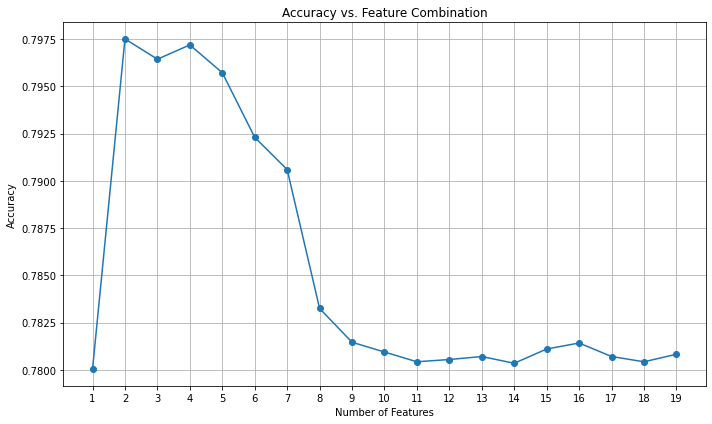

In [12]:
# Initialise empty lists to store results
feature_combinations = []
accuracies = []

# Conduct experiments by training and evaluating the model on different feature combinations
for feature_combination in range(1, n + 1):
    selected_features_combination = selected_features[:feature_combination]
    X_train_combination = X_train[selected_features_combination]
    X_test_combination = X_test[selected_features_combination]

    rf_classifier_combination = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_combination.fit(X_train_combination, y_train)
    y_pred_combination = rf_classifier_combination.predict(X_test_combination)

    accuracy = accuracy_score(y_test, y_pred_combination)

    # Append results to lists
    feature_combinations.append(feature_combination)
    accuracies.append(accuracy)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(feature_combinations, accuracies, marker='o', linestyle='-')
plt.title("Accuracy vs. Feature Combination")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, n + 1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


#### Try different test sizes and different n estimators

In [13]:
# Define different test sizes and n estimator values to test
test_sizes = [0.2]
n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42, stratify=df[target])

        # Train a Random Forest classifier with the current n estimator value
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Print feature importances for the current test size and n estimator value
        print(f"\nTest Size: {test_size}, n_estimators: {n_estimators_value}")
        print("Feature Importances:")
        print(feature_importances)

        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
            rf_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = rf_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            report = classification_report(y_test, y_pred_selected)
            print(f"Selected Features: {selected_features}")
            print(f"Accuracy: {accuracy}")
            print(f"Classification Report:\n{report}")
            


Test Size: 0.2, n_estimators: 50
Feature Importances:
Agency                     0.568212
WorkflowStatus             0.177457
UWDecision                 0.099782
CommDateProvided           0.037087
SignedDecReceived          0.014222
NoOfLives                  0.013113
BonusCommission            0.012710
ProductGroup               0.012109
SeriousIllnessType         0.011081
CommissionTerms            0.010930
Product                    0.010863
Indexation                 0.009646
ProductType                0.005605
CommissionSacrificeType    0.003944
RenewalSacrificeType       0.003862
ComissionSacrifice         0.003201
Discount                   0.002941
PaymentFreq                0.002637
FreeCover                  0.000598
dtype: float64
Selected Features: ['Agency']
Accuracy: 0.7791113583975836
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.04      0.07      5578
           1       0.78      0.99      0.87     19584



Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'ProductGroup', 'SeriousIllnessType', 'CommissionTerms', 'Product', 'Indexation', 'ProductType', 'CommissionSacrificeType', 'RenewalSacrificeType', 'ComissionSacrifice']
Accuracy: 0.780184405055242
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      5578
           1       0.84      0.89      0.86     19584

    accuracy                           0.78     25162
   macro avg       0.67      0.64      0.65     25162
weighted avg       0.76      0.78      0.77     25162

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'ProductGroup', 'SeriousIllnessType', 'CommissionTerms', 'Product', 'Indexation', 'ProductType', 'CommissionSacrificeType', 'RenewalSacrificeType', 'ComissionSacrifice', 'Discount']


Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product', 'SeriousIllnessType', 'CommissionTerms', 'ProductGroup']
Accuracy: 0.780422859868055
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      5578
           1       0.84      0.89      0.86     19584

    accuracy                           0.78     25162
   macro avg       0.67      0.65      0.66     25162
weighted avg       0.77      0.78      0.77     25162

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product', 'SeriousIllnessType', 'CommissionTerms', 'ProductGroup', 'Indexation']
Accuracy: 0.7805420872744615
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      5578
           1       0.84      0.89      0.

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived']
Accuracy: 0.7959621651697003
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.39      0.46      5578
           1       0.84      0.91      0.87     19584

    accuracy                           0.80     25162
   macro avg       0.70      0.65      0.67     25162
weighted avg       0.78      0.80      0.78     25162

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives']
Accuracy: 0.7931007074159446
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.39      0.45      5578
           1       0.84      0.91      0.87     19584

    accuracy                           0.79     25162
   macro avg       0.69      0.65      0.66     25162
weighted avg       0.77      0.79      0.78     25162

Selected Features: ['Ag

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product', 'SeriousIllnessType', 'ProductGroup', 'CommissionTerms', 'Indexation', 'ProductType', 'RenewalSacrificeType', 'CommissionSacrificeType', 'ComissionSacrifice', 'Discount', 'PaymentFreq', 'FreeCover']
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.40      0.44      5578
           1       0.84      0.89      0.86     19584

    accuracy                           0.78     25162
   macro avg       0.67      0.64      0.65     25162
weighted avg       0.76      0.78      0.77     25162



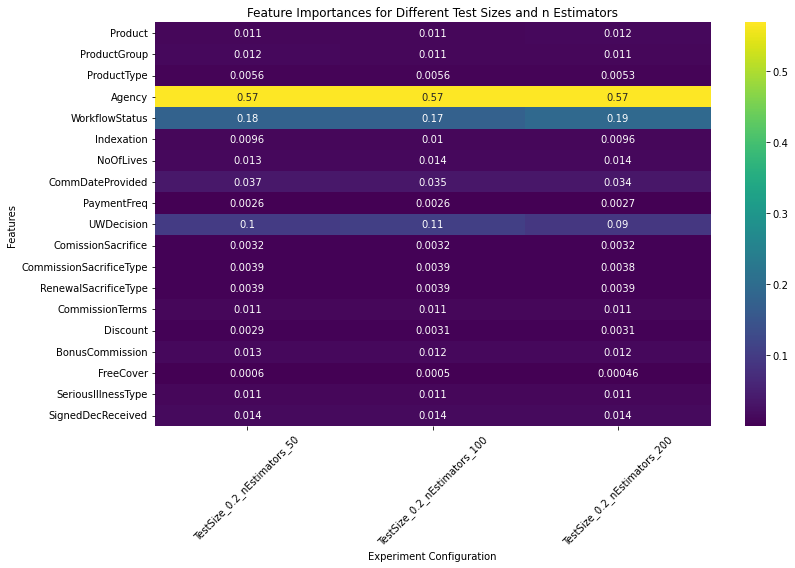

In [14]:
# Create an empty DataFrame to store feature importances
feature_importance_df = pd.DataFrame(index=features)

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42, stratify=df[target])

        # Train a Random Forest classifier with the current n estimator value
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in the DataFrame
        feature_importance_df[f"TestSize_{test_size}_nEstimators_{n_estimators_value}"] = feature_importances

# Create a heatmap to visualise feature importances
plt.figure(figsize=(12, 8))
sns.heatmap(feature_importance_df, cmap='viridis', annot=True)
plt.title("Feature Importances for Different Test Sizes and n Estimators")
plt.xlabel("Experiment Configuration")
plt.ylabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
# Create empty lists to store results
results = []
feature_importances_dict = {}

n_values = list(range(1, 8))

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42,stratify=df[target])

        # Train a Random Forest classifier with the current n estimator value
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in dictionary for visualization
        feature_importances_dict[(test_size, n_estimators_value)] = feature_importances

        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
            rf_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = rf_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            results.append((test_size, n_estimators_value, n, accuracy))
            
results


[(0.2, 50, 1, 0.7791113583975836),
 (0.2, 50, 2, 0.7972339241713695),
 (0.2, 50, 3, 0.7977903187345998),
 (0.2, 50, 4, 0.7984261982354344),
 (0.2, 50, 5, 0.7960019076385025),
 (0.2, 50, 6, 0.7934583896351641),
 (0.2, 50, 7, 0.7917494634766712),
 (0.2, 100, 1, 0.7800254351800334),
 (0.2, 100, 2, 0.7975121214529847),
 (0.2, 100, 3, 0.7964390747953263),
 (0.2, 100, 4, 0.7971941817025674),
 (0.2, 100, 5, 0.7957237103568874),
 (0.2, 100, 6, 0.7923058580399014),
 (0.2, 100, 7, 0.7905969318814084),
 (0.2, 200, 1, 0.7795882680232096),
 (0.2, 200, 2, 0.7966775296081393),
 (0.2, 200, 3, 0.7971544392337652),
 (0.2, 200, 4, 0.7978698036722042),
 (0.2, 200, 5, 0.7959621651697003),
 (0.2, 200, 6, 0.7931007074159446),
 (0.2, 200, 7, 0.7908751291630236)]

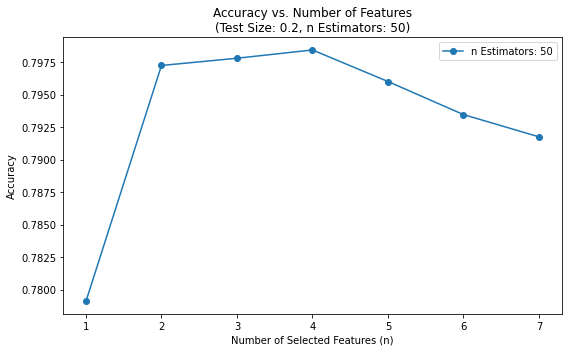

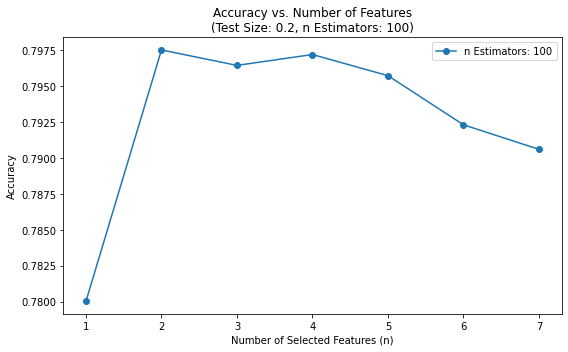

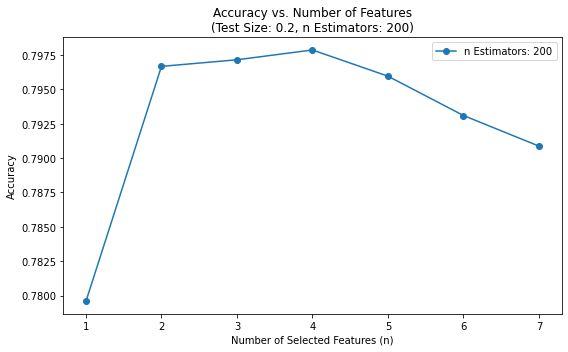

In [16]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(results, columns=["TestSize", "nEstimators", "nFeatures", "Accuracy"])

# Create line plots for each test size and n estimator combination
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        plt.figure(figsize=(8, 5))
        plt.title(f"Accuracy vs. Number of Features\n(Test Size: {test_size}, n Estimators: {n_estimators_value})")
        plt.xlabel("Number of Selected Features (n)")
        plt.ylabel("Accuracy")
        
        subset_df = results_df[(results_df["TestSize"] == test_size) & (results_df["nEstimators"] == n_estimators_value)]
        
        plt.plot(subset_df["nFeatures"], subset_df["Accuracy"], marker='o', linestyle='-', label=f"n Estimators: {n_estimators_value}")
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        

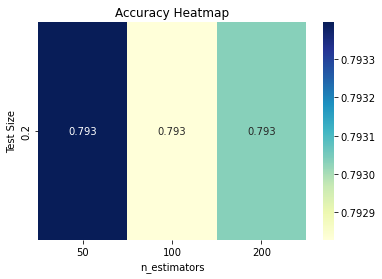

In [17]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

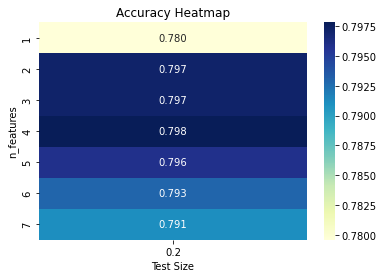

In [18]:
# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

The feature importance scoring built into random forest appears to be suggesting that the same four independent variables as identifed with Cramer's V are the most important predictors of Policy Issuance.

### Gradient Boosting Feature Importance Scoring

In [6]:
# Define different test sizes and n estimator values to test
test_sizes = [0.2]
n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

# Define features and target variable
features = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']
target = 'PolicyIssued'


In [16]:
# Create empty lists to store results
results = []

# Define different n estimator values to test
n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

# Iterate through each n estimator value
for n_estimators_value in n_estimators_values:
    # Split the data into training and testing sets with the current test size
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])

    # Train a Gradient Boosting classifier
    gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
    gb_classifier.fit(X_train, y_train)

    # Get feature importances
    feature_importances = pd.Series(gb_classifier.feature_importances_, index=features).sort_values(ascending=False)

    # Print feature importances for the current test size and n estimator value
    print(f"\n_estimators: {n_estimators_value}")
    print("Feature Importances:")
    print(feature_importances)

    # Select the top-n features based on importance
    for n in n_values:
        selected_features = feature_importances[:n].index.tolist()

        # Create a new dataset with the selected features
        selected_data = df[selected_features + [target]]

        # Train and evaluate the model with the current feature combination
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        gb_classifier_selected = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
        gb_classifier_selected.fit(X_train_selected, y_train)
        y_pred_selected = gb_classifier_selected.predict(X_test_selected)

        accuracy = accuracy_score(y_test, y_pred_selected)
        report = classification_report(y_test, y_pred_selected)
        results.append((n_estimators_value, n, accuracy))
        print(f"Selected Features: {selected_features}")
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{report}")
            


_estimators: 50
Feature Importances:
WorkflowStatus             0.732134
Agency                     0.123139
UWDecision                 0.056600
ProductGroup               0.028173
CommDateProvided           0.017467
Product                    0.012451
BonusCommission            0.010935
NoOfLives                  0.010820
ProductType                0.003844
SignedDecReceived          0.003841
Indexation                 0.000516
CommissionTerms            0.000078
PaymentFreq                0.000000
ComissionSacrifice         0.000000
CommissionSacrificeType    0.000000
RenewalSacrificeType       0.000000
Discount                   0.000000
FreeCover                  0.000000
SeriousIllnessType         0.000000
dtype: float64
Selected Features: ['WorkflowStatus']
Accuracy: 0.7783959939591447
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      5578
           1       0.78      1.00      0.88     19584

    accur

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives', 'ProductType', 'SignedDecReceived', 'Indexation', 'CommissionTerms', 'PaymentFreq', 'ComissionSacrifice', 'CommissionSacrificeType', 'RenewalSacrificeType']
Accuracy: 0.8006120340195533
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.21      0.32      5578
           1       0.81      0.97      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.73      0.59      0.60     25162
weighted avg       0.78      0.80      0.76     25162

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives', 'ProductType', 'SignedDecReceived', 'Indexation', 'CommissionTerms', 'PaymentFreq', 'ComissionSacrifice', 'CommissionSacrificeType', 'RenewalSacrificeType', 'Discount']
Accuracy: 0.8

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives', 'ProductType', 'SignedDecReceived', 'Indexation']
Accuracy: 0.8009697162387728
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.23      0.34      5578
           1       0.81      0.96      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.73      0.60      0.61     25162
weighted avg       0.78      0.80      0.76     25162

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives', 'ProductType', 'SignedDecReceived', 'Indexation', 'SeriousIllnessType']
Accuracy: 0.8010094587075749
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.23      0.34      5578
           1       0.81      0.96      0.88     19584

 

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided']
Accuracy: 0.8004928066131468
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.23      0.34      5578
           1       0.81      0.96      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.73      0.60      0.61     25162
weighted avg       0.78      0.80      0.76     25162

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product']
Accuracy: 0.8018043080836181
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.25      0.36      5578
           1       0.82      0.96      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.73      0.60      0.62     25162
weighted avg       0.78      0.80      0.77     25162

Selected Features: ['WorkflowStatus

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives', 'ProductType', 'SignedDecReceived', 'SeriousIllnessType', 'Indexation', 'CommissionTerms', 'CommissionSacrificeType', 'ComissionSacrifice', 'Discount', 'RenewalSacrificeType', 'PaymentFreq', 'FreeCover']
Accuracy: 0.8027978698036722
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.26      0.36      5578
           1       0.82      0.96      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.73      0.61      0.62     25162
weighted avg       0.78      0.80      0.77     25162



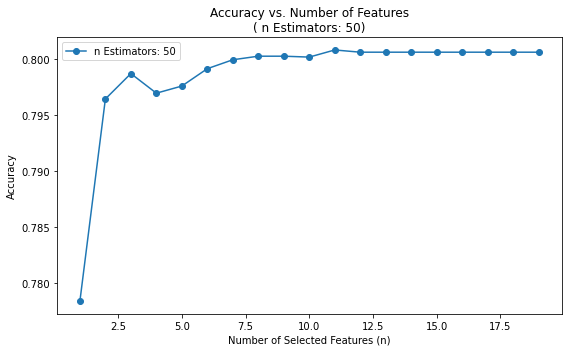

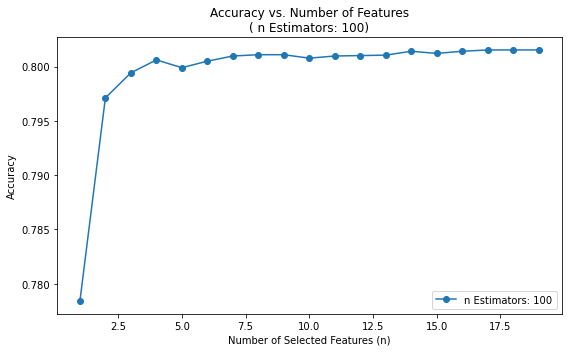

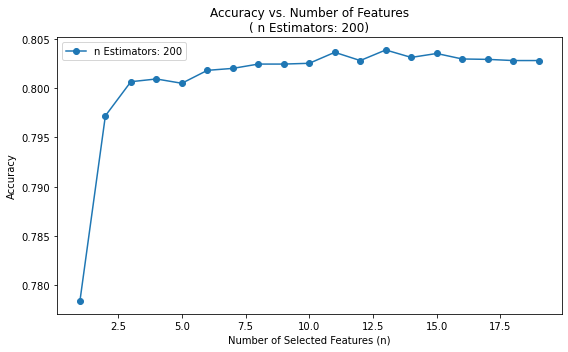

In [17]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=[ "nEstimators", "nFeatures", "Accuracy"])

# Create line plots for each n estimator 
for n_estimators_value in n_estimators_values:
        plt.figure(figsize=(8, 5))
        plt.title(f"Accuracy vs. Number of Features\n( n Estimators: {n_estimators_value})")
        plt.xlabel("Number of Selected Features (n)")
        plt.ylabel("Accuracy")
        
        subset_df = results_df[(results_df["nEstimators"] == n_estimators_value)]
        
        plt.plot(subset_df["nFeatures"], subset_df["Accuracy"], marker='o', linestyle='-', label=f"n Estimators: {n_estimators_value}")
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        

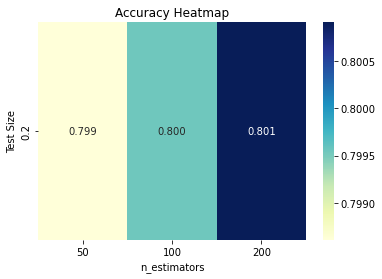

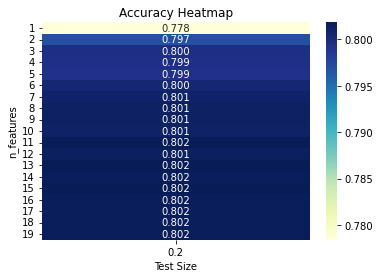

In [22]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

### LightGBM Feature Importance Scoring

In [19]:
# Create empty lists to store results
results = []

# Define different n estimator values to test
n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

# Iterate through each n estimator value
for n_estimators_value in n_estimators_values:
    # Split the data into training and testing sets with the current test size
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])

    # Train a Gradient Boosting classifier
    lgb_classifier = lgb.LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
    lgb_classifier.fit(X_train, y_train)

    # Get feature importances
    feature_importances = pd.Series(lgb_classifier.feature_importances_, index=features).sort_values(ascending=False)

    # Print feature importances for the current test size and n estimator value
    print(f"\nn_estimators: {n_estimators_value}")
    print("Feature Importances:")
    print(feature_importances)

    # Select the top-n features based on importance
    for n in n_values:
        selected_features = feature_importances[:n].index.tolist()

        # Create a new dataset with the selected features
        selected_data = df[selected_features + [target]]

        # Train and evaluate the model with the current feature combination
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        lgb_classifier_selected = lgb.LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
        lgb_classifier_selected.fit(X_train_selected, y_train)
        y_pred_selected = lgb_classifier_selected.predict(X_test_selected)

        accuracy = accuracy_score(y_test, y_pred_selected)
        report = classification_report(y_test, y_pred_selected)
        results.append((n_estimators_value, n, accuracy))
        print(f"Selected Features: {selected_features}")
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{report}")
            


_estimators: 50
Feature Importances:
Agency                     963
UWDecision                  78
CommDateProvided            74
SignedDecReceived           58
ProductType                 56
WorkflowStatus              40
NoOfLives                   40
ProductGroup                34
BonusCommission             32
Product                     28
SeriousIllnessType          26
CommissionTerms             16
CommissionSacrificeType     15
ComissionSacrifice          14
Indexation                  13
Discount                     9
PaymentFreq                  2
FreeCover                    2
RenewalSacrificeType         0
dtype: int32
Selected Features: ['Agency']
Accuracy: 0.7803433749304507
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.03      0.06      5578
           1       0.78      0.99      0.88     19584

    accuracy                           0.78     25162
   macro avg       0.69      0.51      0.47     25162
weight

Selected Features: ['Agency', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'ProductType', 'WorkflowStatus', 'NoOfLives', 'ProductGroup', 'BonusCommission', 'Product', 'SeriousIllnessType', 'CommissionTerms', 'CommissionSacrificeType', 'ComissionSacrifice', 'Indexation', 'Discount']
Accuracy: 0.8028376122724744
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.35      0.44      5578
           1       0.83      0.93      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.71      0.64      0.66     25162
weighted avg       0.78      0.80      0.78     25162

Selected Features: ['Agency', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'ProductType', 'WorkflowStatus', 'NoOfLives', 'ProductGroup', 'BonusCommission', 'Product', 'SeriousIllnessType', 'CommissionTerms', 'CommissionSacrificeType', 'ComissionSacrifice', 'Indexation', 'Discount', 'PaymentFreq']
Accuracy: 0.80307606

Selected Features: ['Agency', 'ProductType', 'SignedDecReceived', 'SeriousIllnessType', 'ProductGroup', 'NoOfLives', 'UWDecision', 'CommDateProvided', 'BonusCommission', 'Indexation', 'WorkflowStatus']
Accuracy: 0.8013273984579922
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.36      0.44      5578
           1       0.84      0.93      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.71      0.64      0.66     25162
weighted avg       0.78      0.80      0.78     25162

Selected Features: ['Agency', 'ProductType', 'SignedDecReceived', 'SeriousIllnessType', 'ProductGroup', 'NoOfLives', 'UWDecision', 'CommDateProvided', 'BonusCommission', 'Indexation', 'WorkflowStatus', 'CommissionTerms']
Accuracy: 0.8014068833955965
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.36      0.44      5578
           1       0.84      0.93    

Selected Features: ['Agency', 'ProductGroup', 'SeriousIllnessType', 'NoOfLives', 'SignedDecReceived']
Accuracy: 0.7780383117399253
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.05      0.09      5578
           1       0.78      0.99      0.87     19584

    accuracy                           0.78     25162
   macro avg       0.64      0.52      0.48     25162
weighted avg       0.72      0.78      0.70     25162

Selected Features: ['Agency', 'ProductGroup', 'SeriousIllnessType', 'NoOfLives', 'SignedDecReceived', 'BonusCommission']
Accuracy: 0.7792703282727923
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.06      0.11      5578
           1       0.79      0.98      0.87     19584

    accuracy                           0.78     25162
   macro avg       0.65      0.52      0.49     25162
weighted avg       0.73      0.78      0.70     25162

Selected Features: 

Selected Features: ['Agency', 'ProductGroup', 'SeriousIllnessType', 'NoOfLives', 'SignedDecReceived', 'BonusCommission', 'ProductType', 'Indexation', 'CommissionTerms', 'CommDateProvided', 'UWDecision', 'ComissionSacrifice', 'Product', 'WorkflowStatus', 'CommissionSacrificeType', 'RenewalSacrificeType', 'Discount', 'PaymentFreq', 'FreeCover']
Accuracy: 0.7998569271123123
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.36      0.45      5578
           1       0.84      0.92      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.71      0.64      0.66     25162
weighted avg       0.78      0.80      0.78     25162



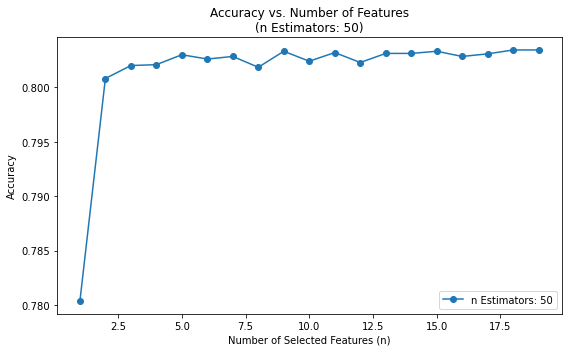

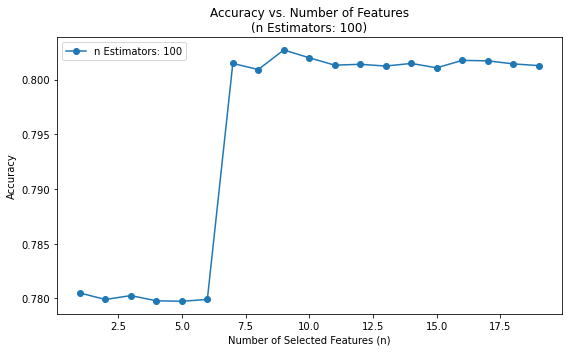

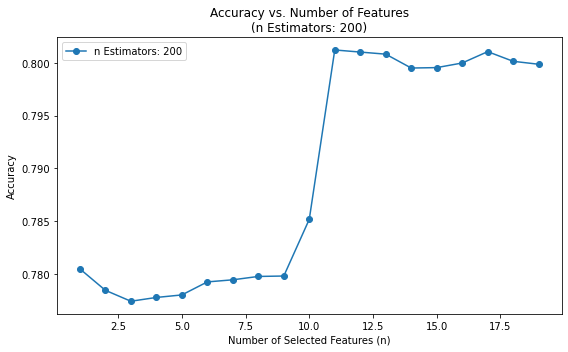

In [20]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=["nEstimators", "nFeatures", "Accuracy"])

# Create line plots for each n estimator
for n_estimators_value in n_estimators_values:
    plt.figure(figsize=(8, 5))
    plt.title(f"Accuracy vs. Number of Features\n(n Estimators: {n_estimators_value})")
    plt.xlabel("Number of Selected Features (n)")
    plt.ylabel("Accuracy")

    subset_df = results_df[(results_df["nEstimators"] == n_estimators_value)]

    plt.plot(subset_df["nFeatures"], subset_df["Accuracy"], marker='o', linestyle='-', label=f"n Estimators: {n_estimators_value}")
    plt.legend()

    plt.tight_layout()
    plt.show()


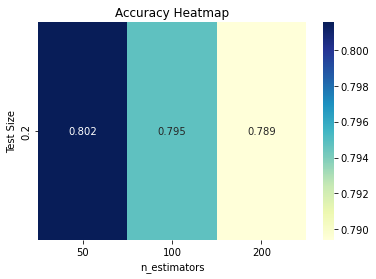

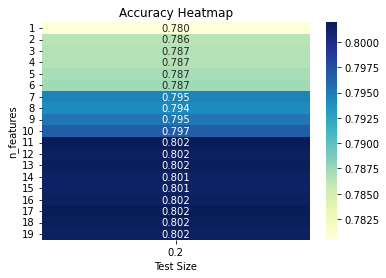

In [25]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()


## Rebalancing imbalanced target variable - Oversampling

#### Class Aware Feature Importance

In [26]:
df = df.drop(columns=['PropDate'])


In [27]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']


In [29]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


Scaler and Borderline SMOTE used in order to avoid the introduction of unrealistic sythetic data points

In [30]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [31]:
# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [32]:
# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [33]:
# Calculate feature importance scores
feature_importance = rf_classifier.feature_importances_


In [34]:
# Calculate class-specific importance
class_labels = df['PolicyIssued'].unique()
class_importance = {}
for label in class_labels:
    mask = (y_train_resampled == label)
    class_importance[label] = feature_importance * mask.mean()


In [35]:
# Combine class-specific importance using weights based on class distribution
class_distribution = y_train_resampled.value_counts(normalize=True)
weighted_importance = sum(class_importance[label] * class_distribution[label] for label in class_labels)


In [36]:
# Print the weighted importance scores for each feature in descending order
importance_scores = [(feature_name, importance_score) for feature_name, importance_score in zip(X.columns, weighted_importance)]
importance_scores_sorted = sorted(importance_scores, key=lambda x: x[1], reverse=True)

for feature_name, importance_score in importance_scores_sorted:
    print(f"Feature: {feature_name}, Weighted Importance: {importance_score:.4f}")


Feature: Agency, Weighted Importance: 0.2138
Feature: WorkflowStatus, Weighted Importance: 0.1199
Feature: BonusCommissionPercentage, Weighted Importance: 0.0342
Feature: UWDecision, Weighted Importance: 0.0326
Feature: CommissionSacrificePercentage, Weighted Importance: 0.0285
Feature: CommDateProvided, Weighted Importance: 0.0267
Feature: SignedDecReceived, Weighted Importance: 0.0090
Feature: NoOfLives, Weighted Importance: 0.0076
Feature: CommissionTerms, Weighted Importance: 0.0044
Feature: SeriousIllnessType, Weighted Importance: 0.0043
Feature: Indexation, Weighted Importance: 0.0040
Feature: Product, Weighted Importance: 0.0036
Feature: ProductGroup, Weighted Importance: 0.0026
Feature: BonusCommission, Weighted Importance: 0.0019
Feature: RenewalSacrificeType, Weighted Importance: 0.0013
Feature: CommissionSacrificeType, Weighted Importance: 0.0012
Feature: Discount, Weighted Importance: 0.0011
Feature: ProductType, Weighted Importance: 0.0010
Feature: ComissionSacrifice, Weig

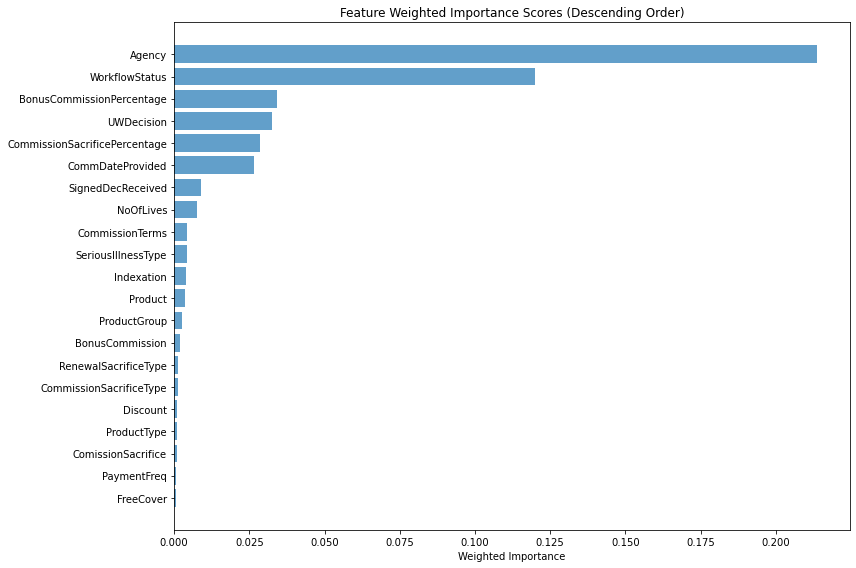

In [37]:
# Extract feature names and importance scores
feature_names, importance_scores = zip(*importance_scores_sorted)

# Create a bar plot to visualize the weighted importance scores
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names)), importance_scores, align='center', alpha=0.7)
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Weighted Importance')
plt.title('Feature Weighted Importance Scores (Descending Order)')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.tight_layout()
plt.show()

### Recursive Feature Elimination with Cross-Validation

#### Random Forest

In [39]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)


Selected features:
Agency
WorkflowStatus


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


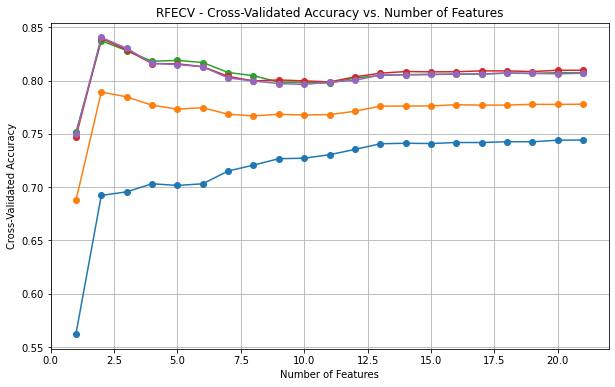

In [40]:
# Plot the cross-validated accuracy vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated Accuracy vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)

# Plot the curve of cross-validated accuracy
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()

In [41]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)


Selected features:
Agency
WorkflowStatus


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


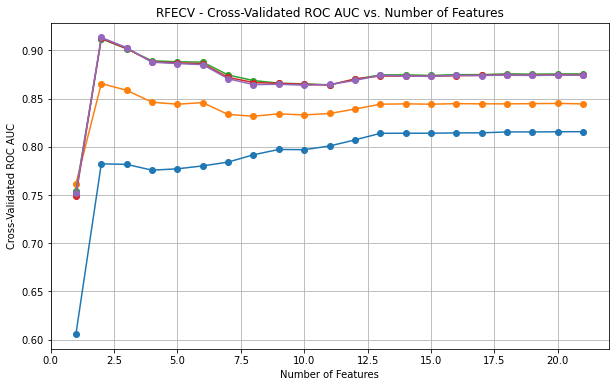

In [42]:
# Plot the cross-validated accuracy vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated ROC AUC vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated ROC AUC")
plt.grid(True)

# Plot the curve of cross-validated accuracy
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()

The result "Selected features: Agency, WorkflowStatus" indicates that the algorithm determined that the two features "Agency" and "WorkflowStatus" are the most important features for predicting the target variable ("PolicyIssued") after applying Recursive Feature Elimination with Cross-Validation (RFECV) on the resampled dataset.

Agency is expected to have a significant predictive value in deciding whether or not a policy will be issued. It implies that the agency linked with the application has a significant impact on the conversion of life assurance applications.

WorkflowStatus element is also crucial in predicting the outcome.

The fact that just these two features were chosen shows that the other features did not contribute as much to the prediction of the target variable, according to the RFECV algorithm. This might imply that these two features include the most essential information for predicting policy issuance.

#### GradientBoostingClassifier

In [44]:
# Train a GradientBoostingClassifier on the resampled data
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=gb_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)
    

Selected features:
ProductGroup
Agency
WorkflowStatus
CommDateProvided
UWDecision
BonusCommissionPercentage


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


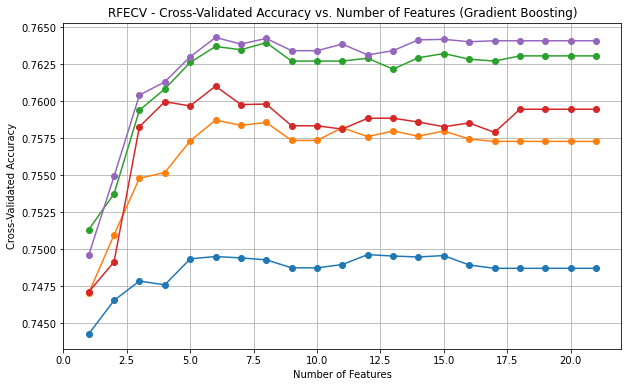

In [45]:
# Plot the cross-validated accuracy vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated Accuracy vs. Number of Features (Gradient Boosting)")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)

# Plot the curve of cross-validated accuracy
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()

In [47]:
# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=gb_classifier, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)
    

Selected features:
Product
ProductGroup
ProductType
Agency
WorkflowStatus
Indexation
NoOfLives
CommDateProvided
PaymentFreq
UWDecision
ComissionSacrifice
CommissionSacrificeType
RenewalSacrificeType
CommissionSacrificePercentage
CommissionTerms
Discount
BonusCommission
BonusCommissionPercentage
SeriousIllnessType
SignedDecReceived


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


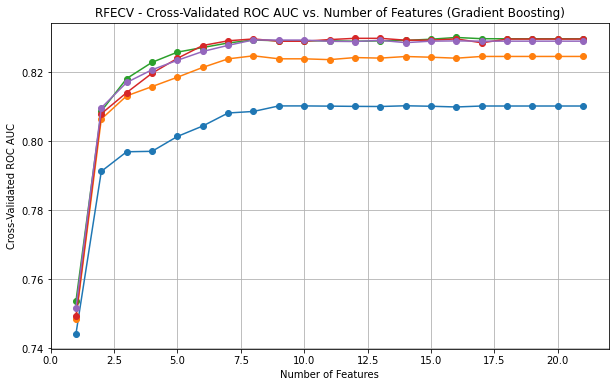

In [48]:
# Plot the cross-validated accuracy vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated ROC AUC vs. Number of Features (Gradient Boosting)")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated ROC AUC")
plt.grid(True)

# Plot the curve of cross-validated accuracy
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()

Agency and WorkflowStatus identified as importantant features, similar to RandomForest RFE.

ProductGroup, NoOfLives, BonusCommissionPercentage, and SignedDecReceived also worth consideration - similar to GBC analysis on imbalanced dataset.

#### LightGBM

In [49]:
# Train a LightGBM classifier on the resampled data
lgb_classifier = LGBMClassifier(random_state=42)
lgb_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=lgb_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)
    

Selected features:
Product
ProductGroup
Agency
WorkflowStatus
Indexation
NoOfLives
CommDateProvided
UWDecision
ComissionSacrifice
RenewalSacrificeType
CommissionSacrificePercentage
CommissionTerms
Discount
BonusCommission
BonusCommissionPercentage
SeriousIllnessType
SignedDecReceived


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


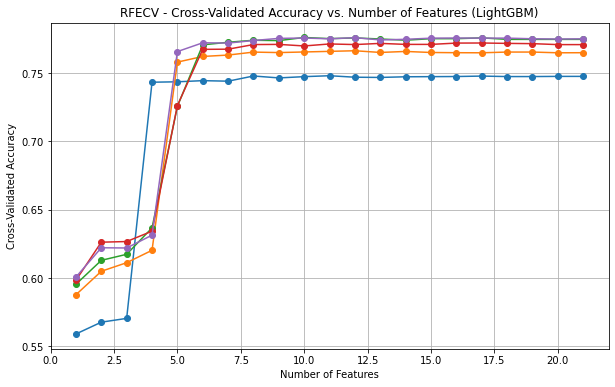

In [50]:
# Plot the cross-validated accuracy vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated Accuracy vs. Number of Features (LightGBM)")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)

# Plot the curve of cross-validated accuracy
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()

In [51]:
# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=lgb_classifier, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)
    

Selected features:
Product
Agency
WorkflowStatus
Indexation
NoOfLives
CommDateProvided
UWDecision
CommissionSacrificePercentage
CommissionTerms
BonusCommissionPercentage
SeriousIllnessType
SignedDecReceived


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


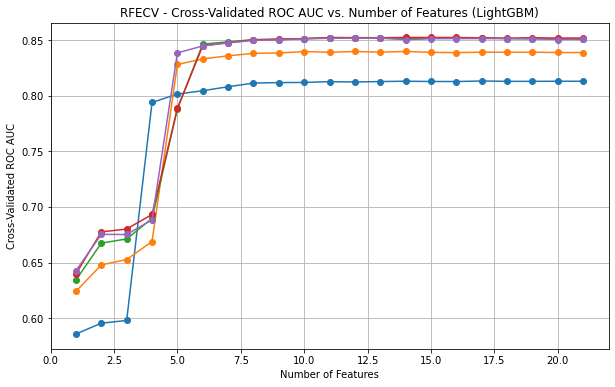

In [52]:
# Plot the cross-validated accuracy vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated ROC AUC vs. Number of Features (LightGBM)")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated ROC AUC")
plt.grid(True)

# Plot the curve of cross-validated accuracy
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()

Similar to the above with the exception of Indexation, CommissionSacrificePercentage and CommissionSacrificePercentage

#### Cramer's V on balanced data

In [53]:
combined_data = np.hstack((X_train_resampled, y_train_resampled.values.reshape(-1, 1)))

# Convert combined_data to a DataFrame
train_data = pd.DataFrame(combined_data, columns=list(X_train.columns) + ['PolicyIssued'])


In [54]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156676 entries, 0 to 156675
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Product                        156676 non-null  float64
 1   ProductGroup                   156676 non-null  float64
 2   ProductType                    156676 non-null  float64
 3   Agency                         156676 non-null  float64
 4   WorkflowStatus                 156676 non-null  float64
 5   Indexation                     156676 non-null  float64
 6   NoOfLives                      156676 non-null  float64
 7   CommDateProvided               156676 non-null  float64
 8   PaymentFreq                    156676 non-null  float64
 9   UWDecision                     156676 non-null  float64
 10  ComissionSacrifice             156676 non-null  float64
 11  CommissionSacrificeType        156676 non-null  float64
 12  RenewalSacrificeType          

In [55]:
train_data.head()

,Product,ProductGroup,ProductType,Agency,WorkflowStatus,Indexation,NoOfLives,CommDateProvided,PaymentFreq,UWDecision,...,RenewalSacrificeType,CommissionSacrificePercentage,CommissionTerms,Discount,BonusCommission,BonusCommissionPercentage,FreeCover,SeriousIllnessType,SignedDecReceived,PolicyIssued
0,-0.858879,-1.068280,0.079233,-0.624052,-1.015368,-0.522535,0.858096,-0.493742,0.059791,1.459405,...,-0.144354,-0.375113,2.685044,-0.093917,0.992517,1.058566,-0.103758,0.119399,-0.699464,0.0
1,1.007433,0.943983,0.079233,-0.091395,0.960467,1.913749,-1.165371,-0.493742,0.059791,-0.711984,...,-0.144354,-0.375113,-0.372433,-0.093917,0.992517,1.417972,-0.103758,0.119399,1.429666,1.0
2,1.007433,0.943983,0.079233,-0.723773,-1.015368,-0.522535,0.858096,-0.493742,0.059791,-0.711984,...,-0.144354,-0.375113,-0.372433,-0.093917,-1.007540,-0.971538,-0.103758,0.119399,-0.699464,1.0
3,-0.858879,-1.068280,0.079233,2.112198,0.960467,-0.522535,-1.165371,-0.493742,0.059791,-0.711984,...,-0.144354,-0.375113,2.685044,-0.093917,-1.007540,-0.971538,-0.103758,0.119399,1.429666,1.0
4,-0.858879,-1.068280,0.079233,-1.361016,-1.015368,-0.522535,0.858096,-0.493742,0.059791,-0.711984,...,-0.144354,-0.375113,-0.372433,-0.093917,-1.007540,-0.971538,-0.103758,0.119399,-0.699464,1.0


In [56]:
for column1 in train_data:
    for column2 in train_data:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            print(f"Chi-square Test: {column1} vs. {column2}")
            print(f"Chi2 Statistic: {chi2}")
            print(f"P-value: {p_value}")
            print()


Chi-square Test: Product vs. ProductGroup
Chi2 Statistic: 39639027.99999997
P-value: 0.0

Chi-square Test: Product vs. ProductType
Chi2 Statistic: 1880111.9999999995
P-value: 0.0

Chi-square Test: Product vs. Agency
Chi2 Statistic: 62174290.09312334
P-value: 0.0

Chi-square Test: Product vs. WorkflowStatus
Chi2 Statistic: 3931794.152445227
P-value: 0.0

Chi-square Test: Product vs. Indexation
Chi2 Statistic: 3170139.386896411
P-value: 0.0

Chi-square Test: Product vs. NoOfLives
Chi2 Statistic: 5199747.277993322
P-value: 0.0

Chi-square Test: Product vs. CommDateProvided
Chi2 Statistic: 158293.95212137338
P-value: 0.0

Chi-square Test: Product vs. PaymentFreq
Chi2 Statistic: 166350.2114822643
P-value: 0.0

Chi-square Test: Product vs. UWDecision
Chi2 Statistic: 4560811.780356105
P-value: 0.0

Chi-square Test: Product vs. ComissionSacrifice
Chi2 Statistic: 476538.4669632408
P-value: 0.0

Chi-square Test: Product vs. CommissionSacrificeType
Chi2 Statistic: 325761.7983753228
P-value: 0.0



Chi-square Test: WorkflowStatus vs. Agency
Chi2 Statistic: 52267226.262984104
P-value: 0.0

Chi-square Test: WorkflowStatus vs. Indexation
Chi2 Statistic: 941541.5571640808
P-value: 0.0

Chi-square Test: WorkflowStatus vs. NoOfLives
Chi2 Statistic: 7209149.89712462
P-value: 0.0

Chi-square Test: WorkflowStatus vs. CommDateProvided
Chi2 Statistic: 1610751.4178468883
P-value: 0.0

Chi-square Test: WorkflowStatus vs. PaymentFreq
Chi2 Statistic: 3619.7942473484154
P-value: 2.269542395297021e-296

Chi-square Test: WorkflowStatus vs. UWDecision
Chi2 Statistic: 12917753.9095668
P-value: 0.0

Chi-square Test: WorkflowStatus vs. ComissionSacrifice
Chi2 Statistic: 1208.3038253559184
P-value: 1.0

Chi-square Test: WorkflowStatus vs. CommissionSacrificeType
Chi2 Statistic: 4462.804946532378
P-value: 1.0

Chi-square Test: WorkflowStatus vs. RenewalSacrificeType
Chi2 Statistic: 5104.274758180656
P-value: 1.0

Chi-square Test: WorkflowStatus vs. CommissionSacrificePercentage
Chi2 Statistic: 20435226.

Chi-square Test: PaymentFreq vs. Agency
Chi2 Statistic: 160116.15017499842
P-value: 0.0

Chi-square Test: PaymentFreq vs. WorkflowStatus
Chi2 Statistic: 3619.794247348415
P-value: 2.269542395297539e-296

Chi-square Test: PaymentFreq vs. Indexation
Chi2 Statistic: 5528.962292102711
P-value: 0.0

Chi-square Test: PaymentFreq vs. NoOfLives
Chi2 Statistic: 12671.782820739298
P-value: 0.0

Chi-square Test: PaymentFreq vs. CommDateProvided
Chi2 Statistic: 982.9057494918317
P-value: 1.8011559969907112e-127

Chi-square Test: PaymentFreq vs. UWDecision
Chi2 Statistic: 163567.0740606157
P-value: 0.0

Chi-square Test: PaymentFreq vs. ComissionSacrifice
Chi2 Statistic: 2018.8814964516966
P-value: 0.0

Chi-square Test: PaymentFreq vs. CommissionSacrificeType
Chi2 Statistic: 2078.031716461476
P-value: 0.0

Chi-square Test: PaymentFreq vs. RenewalSacrificeType
Chi2 Statistic: 158273.31530970923
P-value: 0.0

Chi-square Test: PaymentFreq vs. CommissionSacrificePercentage
Chi2 Statistic: 3852.404727442

Chi-square Test: RenewalSacrificeType vs. Product
Chi2 Statistic: 480147.17693574453
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. ProductGroup
Chi2 Statistic: 479073.903875759
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. ProductType
Chi2 Statistic: 158512.684028394
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. Agency
Chi2 Statistic: 1657817.3746179154
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. WorkflowStatus
Chi2 Statistic: 5104.274758180655
P-value: 1.0

Chi-square Test: RenewalSacrificeType vs. Indexation
Chi2 Statistic: 478977.16249564243
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. NoOfLives
Chi2 Statistic: 173353.02540153
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. CommDateProvided
Chi2 Statistic: 494.498251694536
P-value: 1.0

Chi-square Test: RenewalSacrificeType vs. PaymentFreq
Chi2 Statistic: 158273.31530970923
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. UWDecision
Chi2 Statistic: 326578.3808125063

Chi-square Test: Discount vs. BonusCommissionPercentage
Chi2 Statistic: 22112.865022223214
P-value: 0.0

Chi-square Test: Discount vs. FreeCover
Chi2 Statistic: 9.023552471857439
P-value: 0.002665229024788562

Chi-square Test: Discount vs. SeriousIllnessType
Chi2 Statistic: 282.16940975717205
P-value: 3.495443640319438e-09

Chi-square Test: Discount vs. SignedDecReceived
Chi2 Statistic: 569.5744489688544
P-value: 1.4301034650930977e-11

Chi-square Test: Discount vs. PolicyIssued
Chi2 Statistic: 7.476855192485379
P-value: 0.0062497135141659395

Chi-square Test: BonusCommission vs. Product
Chi2 Statistic: 493288.7789157197
P-value: 0.0

Chi-square Test: BonusCommission vs. ProductGroup
Chi2 Statistic: 476975.81887905684
P-value: 0.0

Chi-square Test: BonusCommission vs. ProductType
Chi2 Statistic: 20115.256492582164
P-value: 0.0

Chi-square Test: BonusCommission vs. Agency
Chi2 Statistic: 12924750.46574524
P-value: 0.0

Chi-square Test: BonusCommission vs. WorkflowStatus
Chi2 Statistic: 

Chi-square Test: SeriousIllnessType vs. UWDecision
Chi2 Statistic: 1573242.5544032464
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. ComissionSacrifice
Chi2 Statistic: 2557.5392920183017
P-value: 3.221243447836291e-14

Chi-square Test: SeriousIllnessType vs. CommissionSacrificeType
Chi2 Statistic: 11974.627976684726
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. RenewalSacrificeType
Chi2 Statistic: 10412.700800151979
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. CommissionSacrificePercentage
Chi2 Statistic: 9724812.19097524
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. CommissionTerms
Chi2 Statistic: 627521.7681871374
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. Discount
Chi2 Statistic: 282.16940975717205
P-value: 3.495443640319438e-09

Chi-square Test: SeriousIllnessType vs. BonusCommission
Chi2 Statistic: 504402.69660987105
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. BonusCommissionPercentage
Chi2 Statistic: 504402.69660987105
P-value:

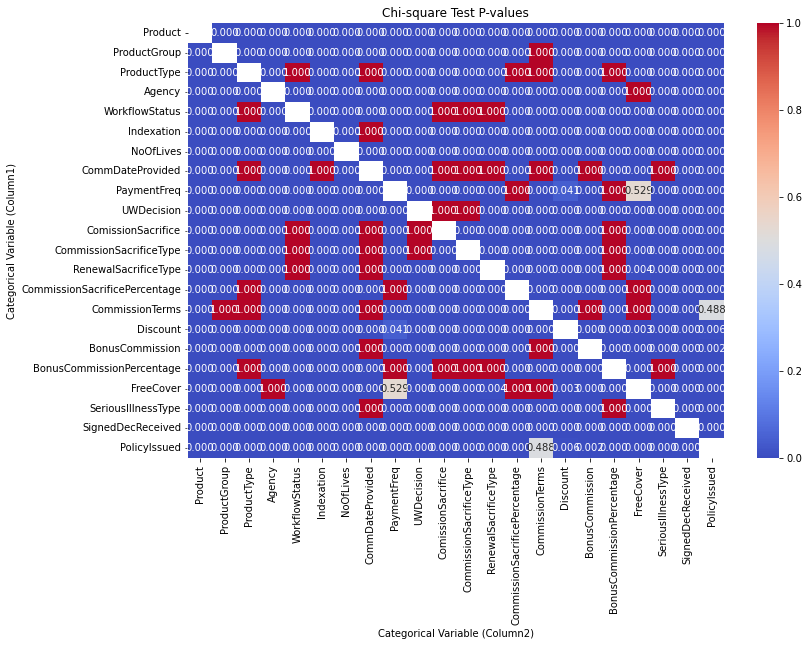

In [57]:
# Initialise an empty DataFrame to store p-values
p_values_df = pd.DataFrame(index=train_data.columns, columns=train_data.columns)

# Loop through each pair of columns and calculate chi-square test p-values
for column1 in train_data.columns:
    for column2 in train_data.columns:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            p_values_df.loc[column1, column2] = p_value

# Convert p-values to numeric format
p_values_df = p_values_df.apply(pd.to_numeric)

# Create a heatmap to visualize p-values
plt.figure(figsize=(12, 8))
sns.heatmap(p_values_df, cmap='coolwarm', annot=True, fmt=".3f")
plt.title("Chi-square Test P-values")
plt.xlabel("Categorical Variable (Column2)")
plt.ylabel("Categorical Variable (Column1)")
plt.show()


In [58]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = np.sum(confusion_matrix)
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corrected = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corrected = r - ((r - 1) ** 2) / (n - 1)
    k_corrected = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corrected / min((k_corrected - 1), (r_corrected - 1)))

# Calculate Cramer's V for variables
for column1 in train_data:
    for column2 in train_data:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            v = cramers_v(contingency_table.values)
            print(f"{column1} vs. {column2}")
            print(f"Cramer's V: {v}")
            print(f"Chi2 Statistic: {chi2}")
            print(f"P-value: {p_value}")
            print()
            

Product vs. ProductGroup
Cramer's V: 0.9992805328880286
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. ProductType
Cramer's V: 0.9985116235167488
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. Agency
Cramer's V: 0.8001513426282002
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. WorkflowStatus
Cramer's V: 0.22249612338357413
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. Indexation
Cramer's V: 0.35489794774854205
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. NoOfLives
Cramer's V: 0.25756495357086767
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. CommDateProvided
Cramer's V: 0.10768761364584399
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. PaymentFreq
Cramer's V: 0.7265185063754445
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. UWDecision
Cramer's V: 0.23091071572841115
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. ComissionSacrifice
Cramer's V: 0.48055585419620

Agency vs. CommissionTerms
Cramer's V: 0.86858726566888
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. Discount
Cramer's V: 0.30434417702496447
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. BonusCommission
Cramer's V: 0.8515304322851579
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. BonusCommissionPercentage
Cramer's V: 0.7414794182353182
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. FreeCover
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. SeriousIllnessType
Cramer's V: 0.8549923460726586
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. SignedDecReceived
Cramer's V: 0.7385713721541982
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. PolicyIssued
Cramer's V: 0.37070202349159204
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

WorkflowStatus vs. Product
Cramer's V: 0.22249612338357413
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

WorkflowStatus vs. ProductGroup
Cramer's V: 0.201780

CommDateProvided vs. PaymentFreq
Cramer's V: 0.05192666643273113
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. UWDecision
Cramer's V: 0.3526774692308085
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. ComissionSacrifice
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. CommissionSacrificeType
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. RenewalSacrificeType
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. CommissionSacrificePercentage
Cramer's V: 0.5173066503253841
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. CommissionTerms
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. Discount
Cramer's V: 0.030182045181818756
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. BonusCommission
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommD

CommissionSacrificeType vs. Product
Cramer's V: 0.41258861669710284
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. ProductGroup
Cramer's V: 0.4132559738180139
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. ProductType
Cramer's V: 0.04129524208843338
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. Agency
Cramer's V: 0.848143939291555
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. WorkflowStatus
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. Indexation
Cramer's V: 0.5042970002427856
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. NoOfLives
Cramer's V: 0.073619926975867
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. CommDateProvided
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. PaymentFreq
Cramer's V: 0.08096365263658635
C

CommissionTerms vs. PaymentFreq
Cramer's V: 0.10465029167645937
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. UWDecision
Cramer's V: 0.2635891530854483
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. ComissionSacrifice
Cramer's V: 0.277282413252228
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. CommissionSacrificeType
Cramer's V: 0.2936833550140466
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. RenewalSacrificeType
Cramer's V: 0.39576442550889473
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. CommissionSacrificePercentage
Cramer's V: 0.5553424646786768
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. Discount
Cramer's V: 0.057253640435052
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. BonusCommission
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. BonusCommissionPercentage
Cramer's V: 0.3660493509364

BonusCommissionPercentage vs. FreeCover
Cramer's V: 0.09815485691712725
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

BonusCommissionPercentage vs. SeriousIllnessType
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

BonusCommissionPercentage vs. SignedDecReceived
Cramer's V: 0.24188438999168774
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

BonusCommissionPercentage vs. PolicyIssued
Cramer's V: 0.1196801033908206
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

FreeCover vs. Product
Cramer's V: 0.11922458528089726
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

FreeCover vs. ProductGroup
Cramer's V: 0.12363348079097326
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

FreeCover vs. ProductType
Cramer's V: 0.029352648470634835
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

FreeCover vs. Agency
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

FreeCover vs. WorkflowStatus
Cramer's V: 0.8468938219491315
Chi2 Statistic: 2521.2118473433775
P-value: 0.0


PolicyIssued vs. PaymentFreq
Cramer's V: 0.01473325478743392
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. UWDecision
Cramer's V: 0.3948913092575033
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. ComissionSacrifice
Cramer's V: 0.01970668859440392
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. CommissionSacrificeType
Cramer's V: 0.02073814296845586
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. RenewalSacrificeType
Cramer's V: 0.023115574073658943
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. CommissionSacrificePercentage
Cramer's V: 0.11531780921649011
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. CommissionTerms
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. Discount
Cramer's V: 0.00642957146674295
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. BonusCommission
Cramer's V: 0.016835178585339994
Chi2 Statistic: 2521.211

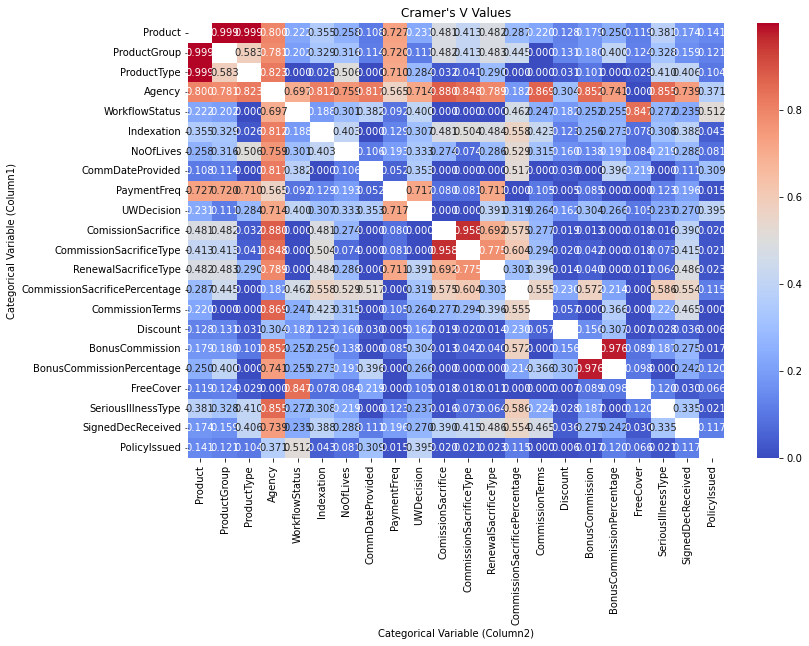

In [59]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = np.sum(confusion_matrix)
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corrected = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corrected = r - ((r - 1) ** 2) / (n - 1)
    k_corrected = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corrected / min((k_corrected - 1), (r_corrected - 1)))

# Initialise an empty DataFrame to store Cramer's V values
cramers_v_df = pd.DataFrame(index=train_data.columns, columns=train_data.columns)

# Loop through each pair of columns and calculate Cramer's V values
for column1 in train_data.columns:
    for column2 in train_data.columns:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            v = cramers_v(contingency_table.values)
            cramers_v_df.loc[column1, column2] = v

# Convert Cramer's V values to numeric format
cramers_v_df = cramers_v_df.apply(pd.to_numeric)

# Create a heatmap to visualize Cramer's V values
plt.figure(figsize=(12, 8))
sns.heatmap(cramers_v_df, cmap='coolwarm', annot=True, fmt=".3f")
plt.title("Cramer's V Values")
plt.xlabel("Categorical Variable (Column2)")
plt.ylabel("Categorical Variable (Column1)")
plt.show()


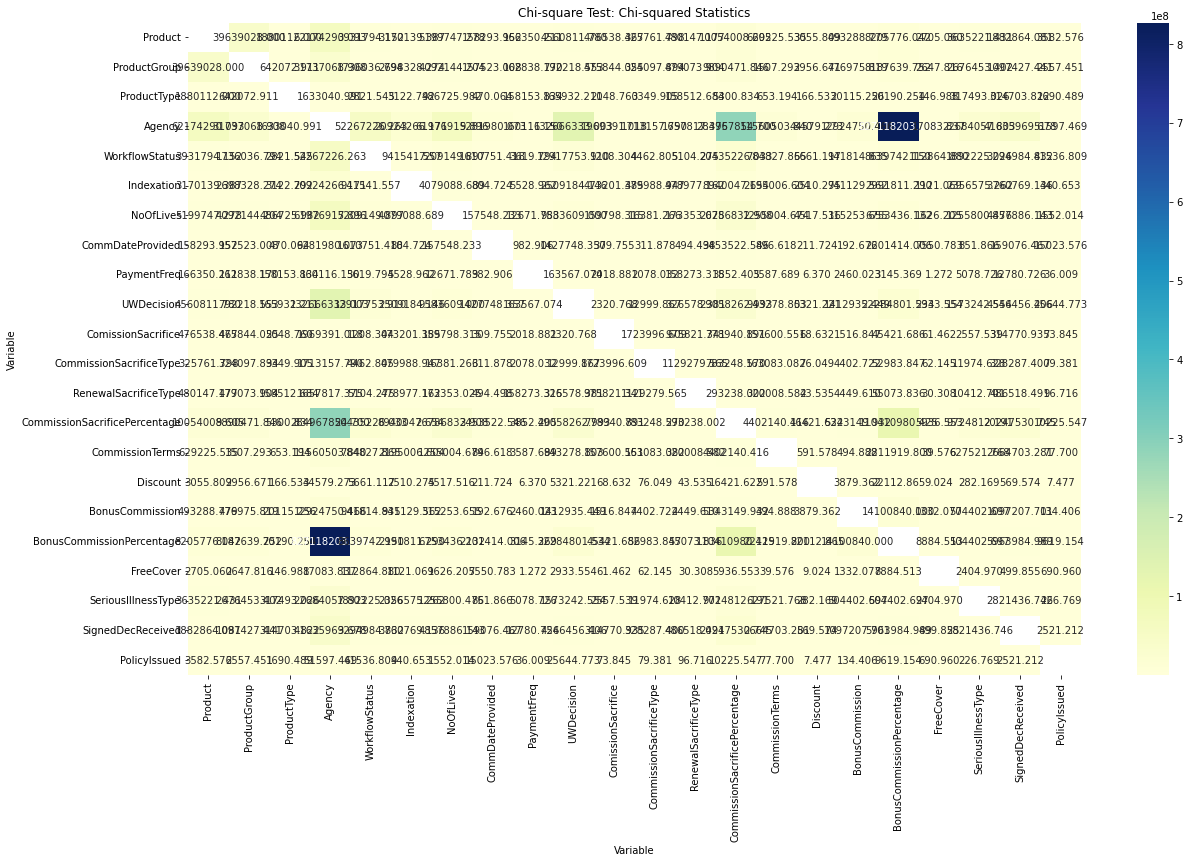

In [60]:
# Create an empty dataframe to store Chi-squared statistics
chi2_stats_df = pd.DataFrame(index=train_data.select_dtypes(include='float64').columns, columns=train_data.select_dtypes(include='float64').columns)

# Perform chi-square test for each pair of categorical variables
for column1 in train_data:
    for column2 in train_data:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2_stat, _, _, _ = chi2_contingency(contingency_table)
            chi2_stats_df.loc[column1, column2] = chi2_stat

# Create a heatmap of the Chi-squared statistics
plt.figure(figsize=(20, 12))
sns.heatmap(chi2_stats_df.astype(float), annot=True, fmt=".3f", cmap='YlGnBu')
plt.xlabel('Variable')
plt.ylabel('Variable')
plt.title('Chi-square Test: Chi-squared Statistics')
plt.show()


When calculated on the balanced dataset, PolicyIssued still seems to have stronger associations with variables like WorkflowStatus, UWDecision, CommDateProvided and Agency.

### Feature Selection Conclusions

Agency and WorkflowStatus occur in the majority of the analyses, implying that they are the most essential variables for predicting the conversion of life assurance apps. UWDecision and CommDateProvided might also be considered because they occur consistently in various techniques. These features might serve as a solid starting point for developing a predictive model. 

In [24]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import lightgbm as lgb

selected_features = ['Agency', 'WorkflowStatus', 'UWDecision','CommDateProvided','SignedDecReceived','NoOfLives']

# Split the data into features (X) and the target variable (y)
X = df[selected_features]
y = df['PolicyIssued']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialise and train a Decision Tree model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

# Make predictions with the Decision Tree model
tree_predictions = tree_model.predict(X_test)
tree_probabilities = tree_model.predict_proba(X_test)[:, 1]

# Calculate accuracy for Decision Tree
tree_accuracy = accuracy_score(y_test, tree_predictions)

# Calculate ROC AUC score for Decision Tree
tree_roc_auc = roc_auc_score(y_test, tree_probabilities)

print("Decision Tree Accuracy:", tree_accuracy)
print("Decision Tree ROC AUC:", tree_roc_auc)
print(classification_report(y_test, tree_predictions))

# Initialize and train a Random Forest model
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

# Make predictions with the Random Forest model
forest_predictions = forest_model.predict(X_test)
forest_probabilities = forest_model.predict_proba(X_test)[:, 1]

# Calculate accuracy for Random Forest
forest_accuracy = accuracy_score(y_test, forest_predictions)

# Calculate ROC AUC score for Random Forest
forest_roc_auc = roc_auc_score(y_test, forest_probabilities)

print("Random Forest Accuracy:", forest_accuracy)
print("Random Forest ROC AUC:", forest_roc_auc)
print(classification_report(y_test, forest_predictions))




selected_features = ['WorkflowStatus', 'Agency','UWDecision','ProductGroup','CommDateProvided',
                     'Product','BonusCommission','NoOfLives','ProductType','SignedDecReceived'
                    ,'Indexation','CommissionTerms']

# Split the data into features (X) and the target variable (y)
X = df[selected_features]
y = df['PolicyIssued']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Gradient Boosting model
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Make predictions with the Gradient Boosting model
gb_predictions = gb_model.predict(X_test)
gb_probabilities = gb_model.predict_proba(X_test)[:, 1]

# Calculate accuracy for Gradient Boosting
gb_accuracy = accuracy_score(y_test, gb_predictions)

# Calculate ROC AUC score for Gradient Boosting
gb_roc_auc = roc_auc_score(y_test, gb_probabilities)

print("Gradient Boosting Accuracy:", gb_accuracy)
print("Gradient Boosting ROC AUC:", gb_roc_auc)
print(classification_report(y_test, gb_predictions))




selected_features = ['Agency','UWDecision','CommDateProvided','SignedDecReceived',
                     'ProductType','WorkflowStatus','NoOfLives','ProductGroup'
                    ,'BonusCommission','Product']

# Split the data into features (X) and the target variable (y)
X = df[selected_features]
y = df['PolicyIssued']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a LightGBM model
lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(X_train, y_train)

# Make predictions with the LightGBM model
lgb_predictions = lgb_classifier.predict(X_test)
lgb_probabilities = lgb_classifier.predict_proba(X_test)[:, 1]

# Calculate accuracy for LightGBM
lgb_accuracy = accuracy_score(y_test, lgb_predictions)

# Calculate ROC AUC score for LightGBM
lgb_roc_auc = roc_auc_score(y_test, lgb_probabilities)

print("LightGBM Accuracy:", lgb_accuracy)
print("LightGBM Boosting ROC AUC:", lgb_roc_auc)
print(classification_report(y_test, lgb_predictions))

Decision Tree Accuracy: 0.7929019950719338
Decision Tree ROC AUC: 0.7803397639261036
              precision    recall  f1-score   support

           0       0.54      0.43      0.48      5577
           1       0.85      0.90      0.87     19585

    accuracy                           0.79     25162
   macro avg       0.69      0.66      0.67     25162
weighted avg       0.78      0.79      0.78     25162

Random Forest Accuracy: 0.7960019076385025
Random Forest ROC AUC: 0.7920011248284455
              precision    recall  f1-score   support

           0       0.56      0.40      0.46      5577
           1       0.84      0.91      0.87     19585

    accuracy                           0.80     25162
   macro avg       0.70      0.65      0.67     25162
weighted avg       0.78      0.80      0.78     25162

Gradient Boosting Accuracy: 0.8020030204276289
Gradient Boosting ROC AUC: 0.8116531164939483
              precision    recall  f1-score   support

           0       0.65     

In [ ]:
df = df.drop(columns=['PropDate'])

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import ttest_ind


# List of features you want to test
features_to_test = ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided']

# Define your hypotheses
hypotheses = {
    'Agency': "The presence of the 'Agency' feature has a positive impact.",
    'WorkflowStatus': "The presence of the 'WorkflowStatus' feature has a positive impact.",
    'UWDecision': "The presence of the 'UWDecision' feature has a positive impact.",
    'CommDateProvided': "The presence of the 'CommDateProvided' feature has a positive impact."
}

# Split the data into features (X) and the target variable (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Initialise empty dictionaries to store results
accuracy_results = {}
roc_auc_results = {}

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialise models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
}

# Loop through each feature to test
for feature in features_to_test:
    # Initialise dictionaries to store results for this feature
    accuracy_feature_results = {}
    roc_auc_feature_results = {}

    # Create control group (without feature manipulation)
    X_control = X_test.copy()

    for model_name, model in models.items():
        # Train the model on the control group
        model.fit(X_train, y_train)

        # Make predictions on the control group
        control_predictions = model.predict(X_control)
        control_probabilities = model.predict_proba(X_control)[:, 1]

        # Calculate accuracy and ROC AUC for the control group
        control_accuracy = accuracy_score(y_test, control_predictions)
        control_roc_auc = roc_auc_score(y_test, control_probabilities)

        accuracy_feature_results[f'Control - {model_name}'] = control_accuracy
        roc_auc_feature_results[f'Control - {model_name}'] = control_roc_auc

        # Create experimental group (with feature manipulation)
        X_experiment = X_test.copy()
        X_experiment[feature] = 0  # Manipulate the feature as per your hypothesis

        # Make predictions on the experimental group
        experiment_predictions = model.predict(X_experiment)
        experiment_probabilities = model.predict_proba(X_experiment)[:, 1]

        # Calculate accuracy and ROC AUC for the experimental group
        experiment_accuracy = accuracy_score(y_test, experiment_predictions)
        experiment_roc_auc = roc_auc_score(y_test, experiment_probabilities)

        accuracy_feature_results[f'Experiment - {model_name}'] = experiment_accuracy
        roc_auc_feature_results[f'Experiment - {model_name}'] = experiment_roc_auc

    # Store the results for this feature
    accuracy_results[feature] = accuracy_feature_results
    roc_auc_results[feature] = roc_auc_feature_results

# Conduct t-tests to determine statistical significance
statistical_significance = {}
for feature in features_to_test:
    accuracy_control_values = list(accuracy_results[feature].values())[:len(models)]
    accuracy_experiment_values = list(accuracy_results[feature].values())[len(models):]

    roc_auc_control_values = list(roc_auc_results[feature].values())[:len(models)]
    roc_auc_experiment_values = list(roc_auc_results[feature].values())[len(models):]

    # Perform t-tests for accuracy and ROC AUC
    accuracy_p_value = ttest_ind(accuracy_control_values, accuracy_experiment_values).pvalue
    roc_auc_p_value = ttest_ind(roc_auc_control_values, roc_auc_experiment_values).pvalue

    # Store p-values for each feature
    statistical_significance[feature] = {
        'Accuracy p-value': accuracy_p_value,
        'ROC AUC p-value': roc_auc_p_value
    }

# Print results and statistical significance
for feature, results in accuracy_results.items():
    print(f"Feature: {feature}")
    for model_name, accuracy in results.items():
        print(f"{model_name} - Accuracy: {accuracy:.4f}")

for feature, results in roc_auc_results.items():
    print(f"Feature: {feature}")
    for model_name, roc_auc in results.items():
        print(f"{model_name} - ROC AUC: {roc_auc:.4f}")

for feature, p_values in statistical_significance.items():
    print(f"Statistical Significance for {feature}:")
    print(f"Accuracy p-value: {p_values['Accuracy p-value']:.4f}")
    print(f"ROC AUC p-value: {p_values['ROC AUC p-value']:.4f}")


Feature: Agency
Control - Decision Tree - Accuracy: 0.7643
Experiment - Decision Tree - Accuracy: 0.7408
Control - Random Forest - Accuracy: 0.7778
Experiment - Random Forest - Accuracy: 0.7585
Control - Gradient Boosting - Accuracy: 0.8020
Experiment - Gradient Boosting - Accuracy: 0.7833
Feature: WorkflowStatus
Control - Decision Tree - Accuracy: 0.7641
Experiment - Decision Tree - Accuracy: 0.5891
Control - Random Forest - Accuracy: 0.7780
Experiment - Random Forest - Accuracy: 0.6561
Control - Gradient Boosting - Accuracy: 0.8020
Experiment - Gradient Boosting - Accuracy: 0.7128
Feature: UWDecision
Control - Decision Tree - Accuracy: 0.7640
Experiment - Decision Tree - Accuracy: 0.7538
Control - Random Forest - Accuracy: 0.7784
Experiment - Random Forest - Accuracy: 0.7740
Control - Gradient Boosting - Accuracy: 0.8020
Experiment - Gradient Boosting - Accuracy: 0.7977
Feature: CommDateProvided
Control - Decision Tree - Accuracy: 0.7642
Experiment - Decision Tree - Accuracy: 0.7608


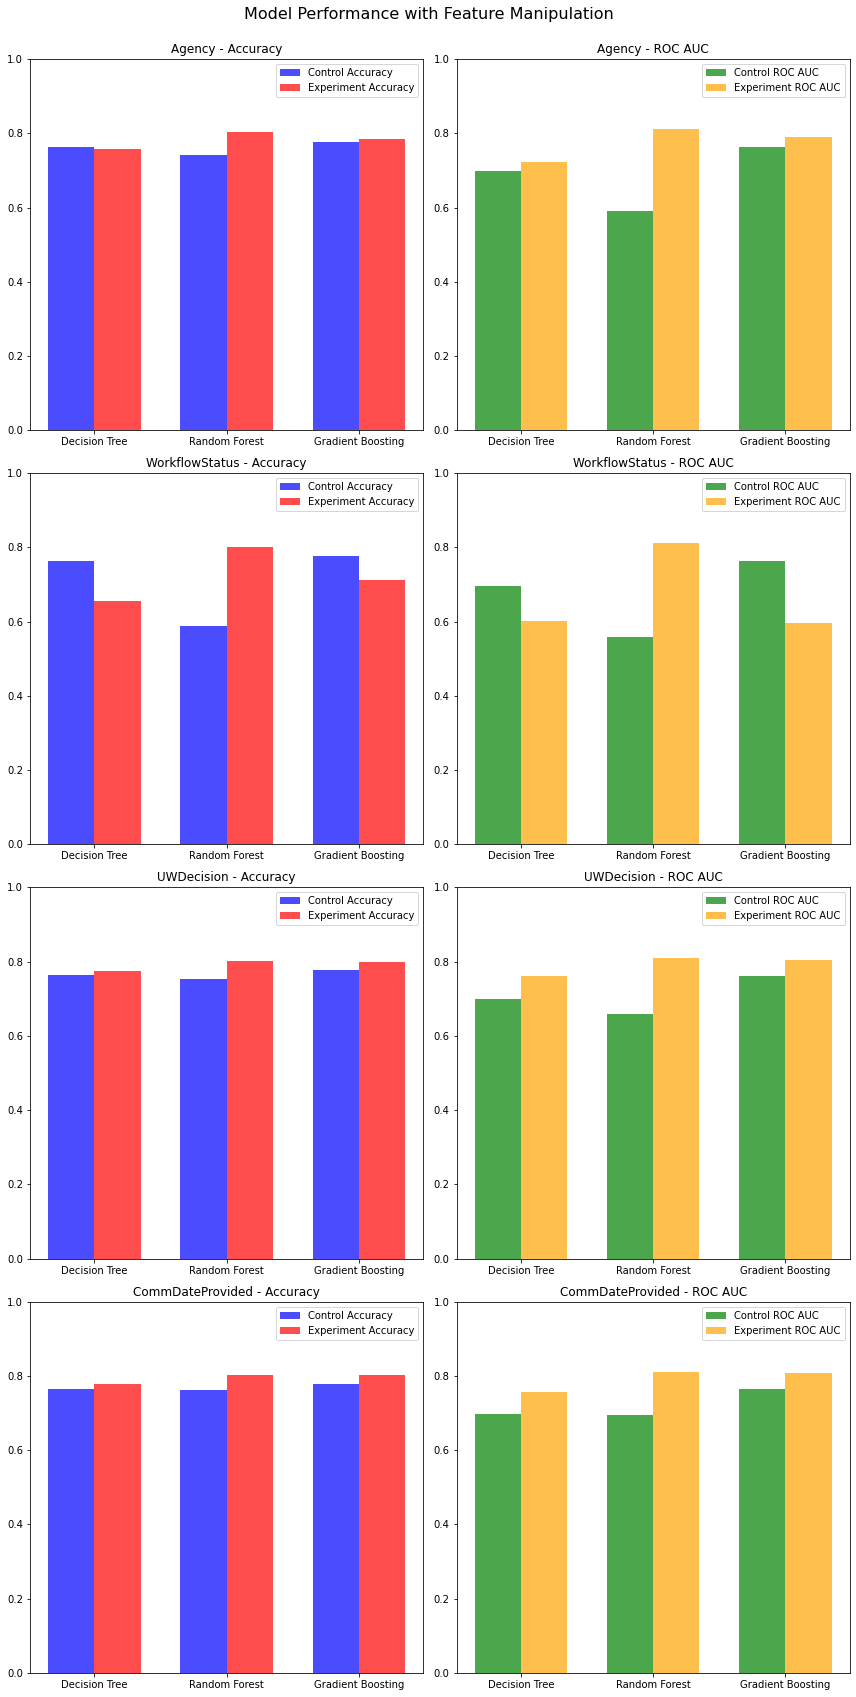

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Create a function to visualise the results
def plot_results(features, metrics, title):
    fig, axs = plt.subplots(len(features), 2, figsize=(12, 6 * len(features)))
    fig.suptitle(title, fontsize=16)
    
    for i, feature in enumerate(features):
        # Accuracy Results
        accuracy_control_values = metrics[feature]['Control']['Accuracy']
        accuracy_experiment_values = metrics[feature]['Experiment']['Accuracy']
        models = metrics[feature]['Models']
        
        bar_width = 0.35
        index = np.arange(len(models))
        
        axs[i, 0].bar(index - bar_width/2, accuracy_control_values, bar_width, color='blue', alpha=0.7, label='Control Accuracy')
        axs[i, 0].bar(index + bar_width/2, accuracy_experiment_values, bar_width, color='red', alpha=0.7, label='Experiment Accuracy')
        axs[i, 0].set_title(f'{feature} - Accuracy')
        axs[i, 0].set_ylim(0, 1)
        axs[i, 0].set_xticks(index)
        axs[i, 0].set_xticklabels(models)
        axs[i, 0].legend()
        
        # ROC AUC Results
        roc_auc_control_values = metrics[feature]['Control']['ROC AUC']
        roc_auc_experiment_values = metrics[feature]['Experiment']['ROC AUC']
        
        axs[i, 1].bar(index - bar_width/2, roc_auc_control_values, bar_width, color='green', alpha=0.7, label='Control ROC AUC')
        axs[i, 1].bar(index + bar_width/2, roc_auc_experiment_values, bar_width, color='orange', alpha=0.7, label='Experiment ROC AUC')
        axs[i, 1].set_title(f'{feature} - ROC AUC')
        axs[i, 1].set_ylim(0, 1)
        axs[i, 1].set_xticks(index)
        axs[i, 1].set_xticklabels(models)
        axs[i, 1].legend()
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Store results in a more structured format
metrics = {}

for feature in features_to_test:
    accuracy_control_values = list(accuracy_results[feature].values())[:len(models)]
    accuracy_experiment_values = list(accuracy_results[feature].values())[len(models):]
    
    roc_auc_control_values = list(roc_auc_results[feature].values())[:len(models)]
    roc_auc_experiment_values = list(roc_auc_results[feature].values())[len(models):]

    # Store accuracy and ROC AUC results for each feature and model type
    metrics[feature] = {
        'Models': [model_name for model_name in models.keys()],
        'Control': {
            'Accuracy': accuracy_control_values,
            'ROC AUC': roc_auc_control_values
        },
        'Experiment': {
            'Accuracy': accuracy_experiment_values,
            'ROC AUC': roc_auc_experiment_values
        }
    }

# Create clustered column charts
plot_results(features_to_test, metrics, 'Model Performance with Feature Manipulation')
